In [24]:
import tensorflow as tf
import numpy as np
import os
from scipy.io import loadmat, savemat
from scipy.stats import entropy

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, LeakyReLU
from tensorflow.keras.utils import plot_model


from sklearn.preprocessing import normalize

train_data_path = '/home/zhaohengguo/Desktop/VMI_Codes_8_by_8/Training_Data/0603/'

vN_t_mesh = [-1.8944, -1.3531, -0.8119, -0.2706, 0.2706, 0.8119, 1.3531, 1.8944]
vN_omega_mesh = [-26.816, -19.1543, -11.4926, -3.8309, 3.8309, 11.4926, 19.1543, 26.8160]

In [2]:
def scale_P2D(P2D):
    """We use this function to rescale the 2D momentum distribution of ionized photoelectrons.
    Input:
    P2D: A N-by-1024 array.
    Output:
    P2D_scale: A N-by-32-by-32-by-1 array."""
    
    P2D = (P2D.T/np.max(P2D, axis = 1).T).T
    P2D_scale = P2D.reshape([-1,32,32,1])
    
    return P2D_scale

def scale_Q(Q):
    """We use this function to scale moduli of vN bases, with each shot normalized to 1.
    Input:
    Q: A N-by-64 complex array.
    Output:
    Q_vN: A N-by-64 real array.
    """
    Q_vN = normalize(np.abs(Q)**2, norm='l1', axis=1)
    
    return Q_vN
    

In [3]:
P2D = loadmat(train_data_path+'P2D_train_737576.mat')['P2D_train']
Q = loadmat(train_data_path+'Q_train_737576.mat')['Q_train']

In [4]:
N_data = np.shape(P2D)[0]
N_val = 400
N_train = N_data-N_val

# Split the data set into the training data set and the test data set
# The training data set
P2D_train_scale = scale_P2D(P2D[0:N_train, :])
Q_vN_train = scale_Q(Q[0:N_train, :])

# The test data set
P2D_val_scale = scale_P2D(P2D[-N_val:, :])
Q_vN_val = scale_Q(Q[-N_val:, :])

In [5]:
# P2D_train_rescale1 = (P2D_train.T/np.max(P2D_train, axis = 1).T).T
# P2D_train_rescale = P2D_train_rescale1.reshape([-1,32,32,1])

# P2D_val = (P2D_val.T/np.max(P2D_val, axis = 1).T).T
# P2D_val_rescale = P2D_val.reshape([-1,32,32,1])

# Q_vN_train = normalize(np.abs(Q_train)**2, norm='l1', axis=1)
# Q_vN_val = normalize(np.abs(Q_val)**2, norm='l1', axis=1)

In [6]:
def vN_generator(VMI_dim):
    """Generate images from a VIM image of size input_dim.
    
    Inputs:
    - z: TensorFlow Tensor of VMI images with shape [batch_size, VMI_dim**2]
    
    Returns:
    TensorFlow Tensor of generated vector potentials, with shape [batch_size, 1].
    """
    model = Sequential([
        Conv2D(64, kernel_size=(4, 4), activation='tanh', input_shape=(VMI_dim, VMI_dim,1)),
        
        Dropout(0.25),
        
        Conv2D(32, (3, 3), activation='tanh'),
        
        Dropout(0.25),
        
        Conv2D(16, (3, 3), activation='tanh'),
        
        Flatten(),
        
        Dense(256, activation='tanh'),
        
        #
        Dense(128, activation='sigmoid'),
        #
        
        Dropout(0.25),
        
        Dense(64),
        
        Activation('softmax'),

    ])
    return model

In [11]:
model = vN_generator(32)
#sgd = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error',optimizer=sgd)

adam_opt = tf.keras.optimizers.Adam(lr = 0.002, beta_1=0.9, beta_2=0.999, decay=1e-6)
model.compile(loss='kullback_leibler_divergence',optimizer=adam_opt)

In [12]:
history = model.fit(P2D_train_scale, Q_vN_train, epochs=20, batch_size=200, validation_data = (P2D_val_scale, Q_vN_val))

Train on 19600 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
19600/19600 [==============================] - 37s 2ms/sample - loss: 0.1504 - val_loss: 0.0548
Epoch 2/20
19600/19600 [==============================] - 35s 2ms/sample - loss: 0.0648 - val_loss: 0.0459
Epoch 3/20
19600/19600 [==============================] - 38s 2ms/sample - loss: 0.0536 - val_loss: 0.0408
Epoch 4/20
19600/19600 [==============================] - 37s 2ms/sample - loss: 0.0477 - val_loss: 0.0375
Epoch 5/20
19600/19600 [==============================] - 37s 2ms/sample - loss: 0.0442 - val_loss: 0.0363
Epoch 6/20
19600/19600 [==============================] - 36s 2ms/sample - loss: 0.0427 - val_loss: 0.0336
Epoch 7/20
19600/19600 [==============================] - 36s 2ms/sample - loss: 0.0401 - val_loss: 0.0316
Epoch 8/20
19600/19600 [==============================] - 36s 2ms/sample - loss: 0.0394 - val_loss: 0.0346
Epoch 9/20
19600/19600 [========================

## Plot the training loss for each epoch

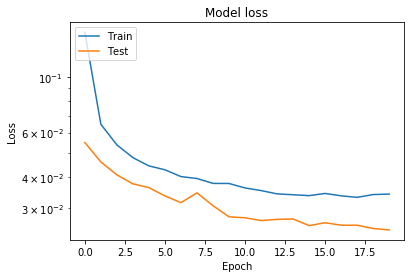

In [41]:
# Plot training & validation loss values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train_err_Q.eps')
plt.show()

## Load the test data

In [42]:
test_data_path = '/home/zhaohengguo/Desktop/VMI_Codes_8_by_8/Training_Data/0604/'
P2D_test = loadmat(test_data_path+'P2D_train_737580.mat')['P2D_train']
Q_test = loadmat(test_data_path+'Q_train_737580.mat')['Q_train']

P2D_test_scale = scale_P2D(P2D_test)
Q_vN_test = scale_Q(Q_test)

## The Kullback–Leibler divergence between the output vN representation and the ground truth vN representation

In [43]:
Q_vN_pred = model.predict(P2D_test_scale)

In [44]:
N_test = Q_test.shape[0]
KL_test = np.zeros(N_test)

for i in range(N_test):
    KL_test[i] = entropy(Q_vN_test[i,:], Q_vN_pred[i,:])
    
print(np.mean(KL_test))

0.03279060133794286


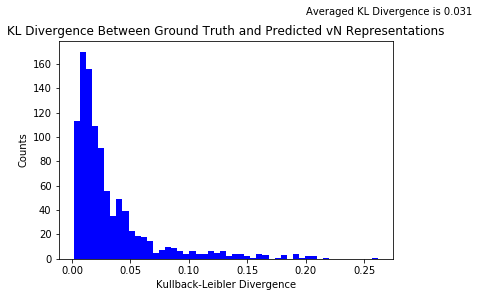

In [45]:
n, bins, patches = plt.hist(np.ravel(KL_test), 50, facecolor='b')


plt.xlabel('Kullback-Leibler Divergence')
plt.ylabel('Counts')
plt.title('KL Divergence Between Ground Truth and Predicted vN Representations')
plt.text(0.2, 200, r'Averaged KL Divergence is 0.031')
plt.savefig('hist_KL_Q_vN.eps')
plt.show()

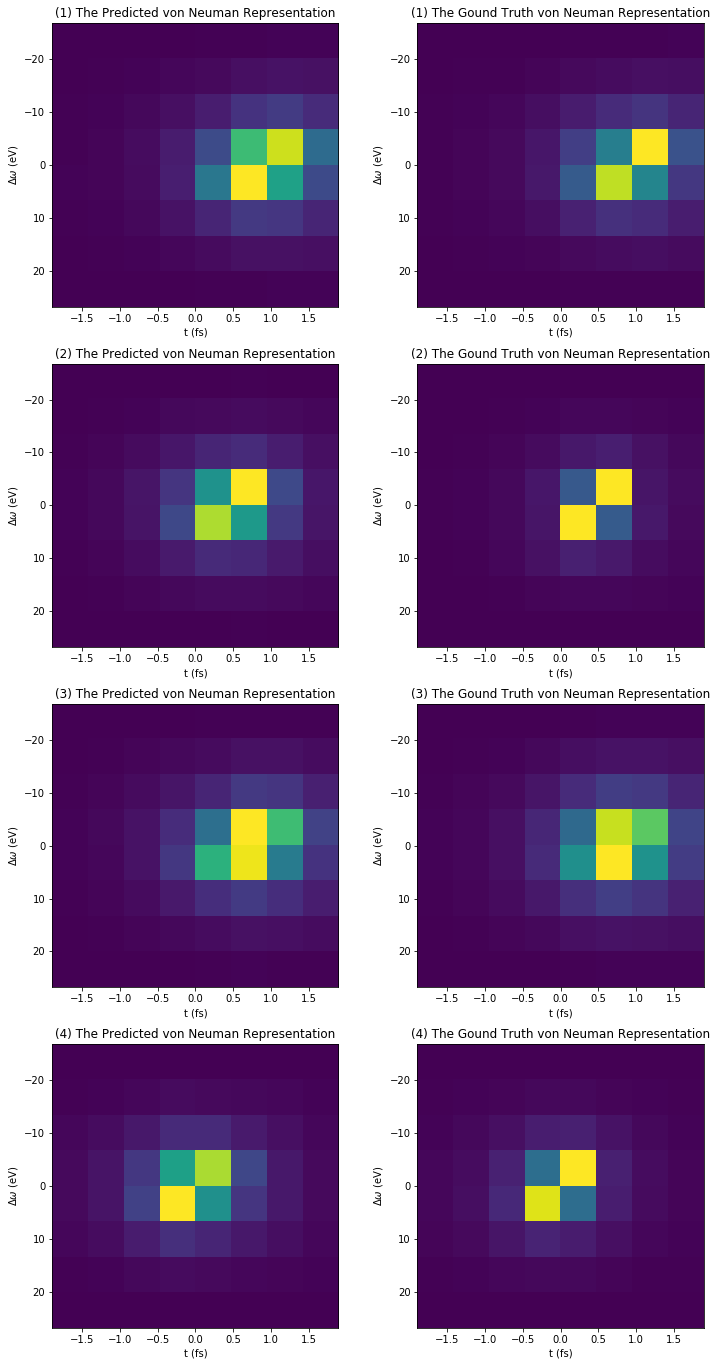

In [46]:
plt.figure(figsize=(12,24))
spi=0

for ind in range(4):
    pic_id = np.random.randint(1000)

    spi+=1
    plt.subplot(4,2,spi)
    plt.imshow(Q_vN_pred[pic_id,:].reshape([8,8]).T, aspect = 0.07, extent=[vN_t_mesh[0],vN_t_mesh[-1],vN_omega_mesh[-1],vN_omega_mesh[0]])        
    plt.xlabel(r't (fs)')
    plt.ylabel(r'$\Delta \omega$ (eV)')
    plt.title('('+str(ind+1)+') The Predicted von Neuman Representation')

    spi+=1
    plt.subplot(4,2,spi)
    
    plt.imshow(Q_vN_test[pic_id,:].reshape([8,8]).T, aspect = 0.07, extent=[vN_t_mesh[0],vN_t_mesh[-1],vN_omega_mesh[-1],vN_omega_mesh[0]])
    plt.xlabel(r't (fs)')
    plt.ylabel(r'$\Delta \omega$ (eV)')
    plt.title('('+str(ind+1)+') The Gound Truth von Neuman Representation')

plt.savefig('pred_Q_vN.eps')
plt.show()

## Transform the predicted von Neuman representation into the inital guess for the nonlinear optimization algorithm

In [47]:
# First we need to scale the vN representation. Previously we have normalized each von Neuman representation to 1. 
# However, the true von Neuman representation calculated from a VMI image is not normalized to 1.
# In other words, we need to find the relation between a VMI image and the order of magnitude of vN representation.

vN_scaling = np.mean(np.sum(np.abs(Q_test)**2, axis = 1))
vN_initial_guess = vN_scaling*Q_vN_pred

x0_initial = np.zeros((N_test, 127))
x0_initial[:,:64] = np.sqrt(vN_initial_guess)
savemat('x0_initial.mat', {"x0_initial": x0_initial})

In [48]:
plot_model(model, to_file='model_Q.png',show_shapes=True, show_layer_names=True)

In [49]:
model.save('Model_Q_Recon')

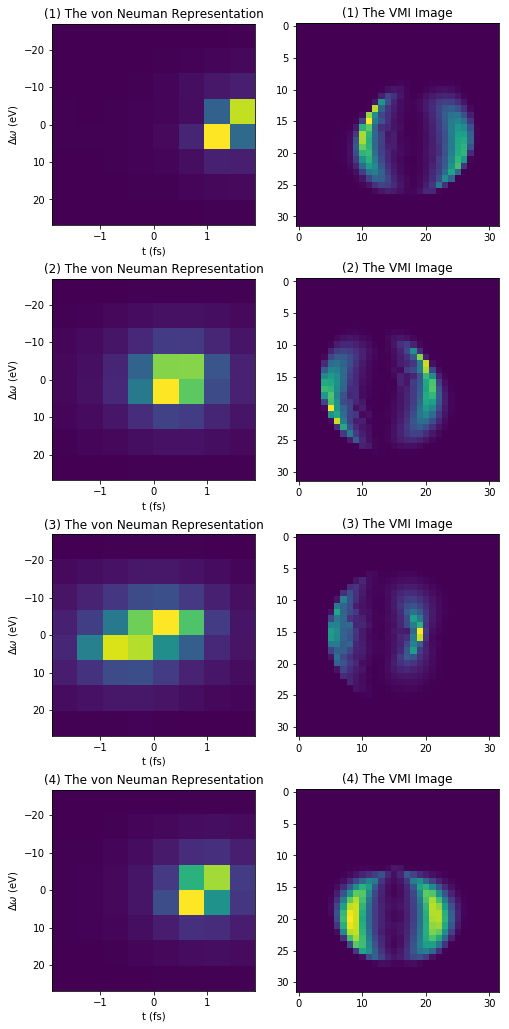

In [50]:
plt.figure(figsize=(8,18))
spi=0

for ind in range(4):
    pic_id = np.random.randint(1000)

    spi+=1
    plt.subplot(4,2,spi)
    plt.imshow(Q_vN_train[pic_id,:].reshape([8,8]).T, aspect = 0.07, extent=[vN_t_mesh[0],vN_t_mesh[-1],vN_omega_mesh[-1],vN_omega_mesh[0]])        
    plt.xlabel(r't (fs)')
    plt.ylabel(r'$\Delta \omega$ (eV)')
    plt.title('('+str(ind+1)+') The von Neuman Representation')

    spi+=1
    plt.subplot(4,2,spi)
    
    plt.imshow(P2D_train_scale[pic_id,:].reshape([32,32]).T)
    plt.title('('+str(ind+1)+') The VMI Image')


plt.savefig('training_data.eps')
plt.show()